## Imports

In [1]:
import scipy.io, random
import numpy as np
from utils import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from scipy import stats

## Utils

In [3]:
def plot_forecast(source, prediction, nrow=5, ncol=5, from_=2800, to_=None, figsize=(10,8), path=None):
    n = source.shape[0]
    idx = list(range(n))
    fig, axs = plt.subplots(nrow, ncol, figsize=figsize, sharex=True)
    if to_ is None:
        to_ = source.shape[1]
    i = 0
    for r in range(nrow):
        for c in range(ncol):
            axs[r,c].plot(range(from_, to_), source[idx[i], from_:to_], c='b', label='Real values')
            axs[r,c].plot(range(from_, to_), prediction[idx[i], from_+1:to_+1], c='r', label='Forecasts')
            axs[r,c].grid()
            i += 1
            
    fig.tight_layout()
    handles, labels = fig.axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, ncol=2, fontsize='large', loc='upper center', bbox_to_anchor=(0.25, 0.55, 0.5, 0.5))
    plt.setp(axs[-1, :], xlabel='Time')
    if path:
        fig.savefig(path, dpi=100, bbox_inches='tight')
        plt.close(fig)    # close the figure window

    else:
        plt.show()

In [4]:
def read_data_from_csv(data_path):
    df = pd.read_csv(data_path)
    X = df.iloc[:, 1:].to_numpy()
    return X

In [5]:
def plot_sf(d, F, F_hat, nrow=5, ncol=5, to_=None, figsize=(10,8), step=10, add=0, path=None):
    fig, axs = plt.subplots(nrow, ncol, figsize=figsize, sharex=True)
    if to_ is None:
        to_ = F.shape[0]
    i = 0
    for r in range(nrow):
        for c in range(ncol):
            axs[r,c].scatter(d[:to_], F[i, :to_,], c='b', label='Actual SF')
            axs[r,c].scatter(d[:to_], F_hat[i, :to_,], c='r', label='Estimated SF')
            axs[r,c].title.set_text(f'Time = {i *step + add}')
            axs[r,c].grid()
            i += 1
            
    fig.tight_layout()
    handles, labels = fig.axes[0].get_legend_handles_labels()
#     fig.legend(handles, labels, ncol=2, fontsize='large', loc='upper center', bbox_to_anchor=(0.25, 0.55, 0.5, 0.5))
    plt.setp(axs[-1, :], xlabel='Distance')
    if path:
        fig.savefig(path, dpi=100, bbox_inches='tight')
        plt.close(fig)    # close the figure window

    else:
        plt.show()

In [5]:
import matplotlib.colors as mcolors
colors = [v for k, v in mcolors.TABLEAU_COLORS.items()]

In [2]:
def get_alphas(path):
    alphas = pd.read_csv(path)
    return alphas.iloc[:, 1:].to_numpy()

## Init

$$W_t = (w^{(t)}_{ij}) = \frac{e^{\hat{f}_t (D_{ij})}}{\sum^n_{j=1} e^{\hat{f}_t (D_{ij})}}$$

In [6]:
ids, d = load_pickle('data/sample.pickle')

# Stationary

## Decreasing Shape Function

In [ ]:
# shape = 'quad' 
shape = 'log'

In [ ]:
alphas = get_alphas(f'data/stationary/csv/alphas.csv')
alphas.shape

In [ ]:
F = []
cutoff = 170
n = alphas.shape[0]
for i in range(n):
    if shape == 'log':
        f = alphas[i, 0] * (-np.log(d+1) + np.log(cutoff))
    else:
        f = alphas[i, 0] * d**2 - 400 * alphas[i, 0] * d + 40000*alphas[i, 0]
    F.append(f)
F = np.array(F)
F.shape

In [ ]:
np.save('data/stationary/csv/F.npy', F)

In [7]:
F = np.load('data/stationary/csv/F.npy')

## Estimation

In [8]:
F_hats = []
actual, forecast = [], []
for i in range(31):
#     out = load_pickle(f'output/stationary/out{i}.pickle')
    out = load_pickle(f'output/test/out{i}.pickle')
    f = out[2].squeeze(-1)
    F_hats.append(f)
    actual.append(out[0])
    forecast.append(out[1])
F_hats = np.stack(F_hats, 0)
actual = np.stack(actual, 0)
forecast = np.stack(forecast, 0)

In [9]:
F_hat_agg = F_hats.mean(0)
F_agg = F[:31, ].mean(0)
F_agg.shape, F_hat_agg.shape

((900,), (900,))

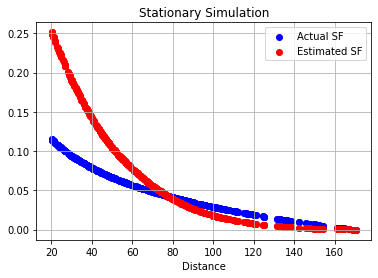

In [10]:
idx = np.argwhere(d > 20)
plt.scatter(d[idx,], F_agg[idx,], c='b', label='Actual SF')
plt.scatter(d[idx,], F_hat_agg[idx, ] , c='r', label='Estimated SF')
plt.grid()
plt.xlabel('Distance')
plt.title('Stationary Simulation')
plt.legend()
# plt.savefig("viz/st_sim/shape_function.pdf", dpi=150)

## Forecasting

In [11]:
actual = actual.mean(0)
forecast = forecast.mean(0)
actual.shape, forecast.shape

((30, 500), (30, 500))

In [12]:
# actual[20, 300:310], forecast[20, 300:310]

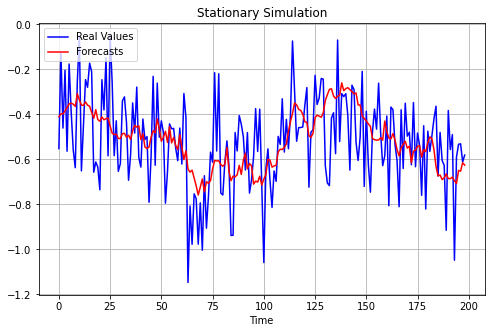

In [13]:
plt.figure(figsize=(8,5))
f, t = 300, 499
loc = 2
plt.plot(actual[loc, f:t], c='b', label='Real Values')
plt.plot(forecast[loc, f+1:t+1], c='r', label='Forecasts')
plt.xlabel('Time')
plt.legend(fontsize='medium', loc='upper left')
plt.title('Stationary Simulation')
plt.grid()
# plt.savefig("viz/st_sim/sample.pdf", dpi=150)

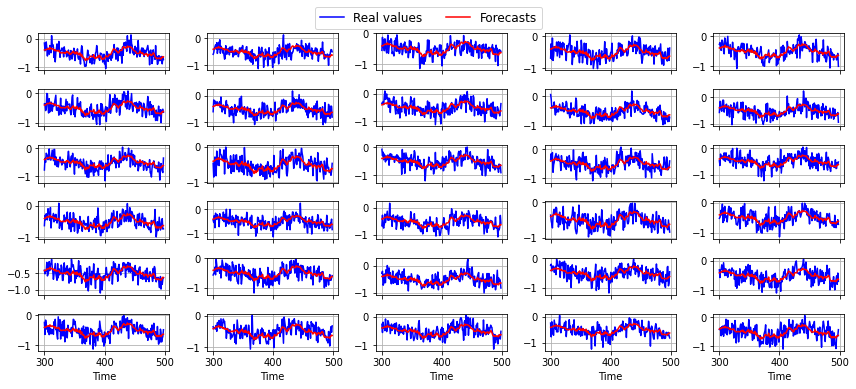

In [14]:
# plot_forecast(actual, forecast, 4, 3, 300, 499, (12,5), 'viz/st_sim/forecast.pdf')
plot_forecast(actual, forecast, 6, 5, 300, 499, (12,5), None)

# Non-Stationary

## Shape function

In [ ]:
shape = 'log'
dataset = 'non_stationary'
alphas = get_alphas(f'data/{dataset}/csv/alphas.csv')

In [ ]:
alphas.shape

In [ ]:
def get_shape_function(d, shape, alpha_1, cutoff):
    if shape == 'log':
        return  alpha_1 * (-np.log(d+1) + np.log(cutoff)) # make it increasing
    elif shape == 'quad': 
        return - alpha_1 * d**2 + 400 * alpha_1 * d # - 40000*alphas_1
        
T = 500
F = []
cutoff=170
n = alphas.shape[0]
for i in tqdm(range(100)):
    fs = []
    alpha = alphas[i, :]
    for t in range(2, T + 1):
        alpha_1 = (1 - (t-1)/T)*alpha[0]+(t-1)/T*alpha[1]
        f = get_shape_function(d, shape, alpha_1, cutoff)
        fs.append(f)
    
    f = get_shape_function(d, shape, alpha[1], cutoff)
    fs.append(f)
    F.append(fs)
F = np.array(F)
F.shape

In [ ]:
np.save(f'data/{dataset}/csv/F.npy', F)
# F = np.load('data/nst_sim/csv/F.npy')

## Estimation

In [ ]:
F_hats = []
actual, forecast = [], []
for i in range(31):
    out = load_pickle(f'output/nst_sim/out{i}.pickle')
    f = out[2].transpose()
    F_hats.append(f)
    actual.append(out[0])
    forecast.append(out[1])
F_hats = np.stack(F_hats)
actual = np.stack(actual, 0)
forecast = np.stack(forecast, 0)

In [ ]:
F.shape, F_hats.shape

In [ ]:
idx = range(300, 400, 4)
F_agg = F[:4, idx, :].mean(0)
F_hat_agg = F_hats[:, idx, :].mean(0)
F_agg.shape, F_hat_agg.shape

In [ ]:
# plot_sf(d, F_agg, F_hat_agg, 4, 5, 900, (13, 6), 5, 300, 'viz/nst_sim/shape_function.pdf')
plot_sf(d, F_agg, F_hat_agg, 5, 5, 900, (13, 8), 5, 300, None)

## Forecasting

In [ ]:
actual = actual.mean(0)
forecast = forecast.mean(0)
actual.shape, forecast.shape

In [ ]:
l = 8
plt.figure(figsize=(8,5))
f, t = 300, 499
plt.plot(actual[1, f:t], c='b', label='Real Values')
plt.plot(forecast[1, f+1:t+1], c='r', label='Forecasts')
plt.xlabel('Time')
plt.legend(fontsize='medium', loc='upper left')
plt.title('Non-Stationary Simulation')
plt.grid()
# plt.savefig("viz/nst_sim/sample.pdf", dpi=150)

In [ ]:
plot_forecast(actual, forecast, 4, 3, 300, 499, (12,6), 'viz/nst_sim/forecast.pdf')
# plot_forecast(actual, forecast, 4, 3, 300, 499, (12,6), None)

## 3. Multi-Step

In [ ]:
h1 = load_pickle('output/nst_sim_h1.pickle')
h2 = load_pickle('output/nst_sim_h10.pickle')

In [ ]:
ts = 500
fig, axs = plt.subplots(1, 2, figsize=(18,8))
axs[0].plot(h1[0][10, -ts:], c='b')
axs[0].plot(h1[1][10, -ts:], c='r')
axs[0].title.set_text('h = 1')

axs[1].plot(h2[0][10, -ts:], c='b')
axs[1].plot(h2[1][10, -ts:], c='r')
axs[1].title.set_text('h = 5')
plt.show()

# Baselines

In [25]:
def aggregate(v, n=7320, h=20, loc=30):
    out = [np.zeros((1, loc)) for _ in range(n)]
    cnt = [np.ones((1, loc)) for _ in range(h)] + [np.zeros((1, loc)) for _ in range(n-h)]
    L = len(y_ids)
    for l in range(L):
        i = y_ids[l] 
        out[i] += v[l, :]
        cnt[i] += 1

    outs = np.concatenate(out)
    cnts = np.concatenate(cnt)
    return (outs/cnts).transpose()

In [26]:
def load_outputs(path, n, h, loc):
    data = np.load(path)
    input, pred, label = data['input'], data['prediction'], data['truth']
    
    
    if 'DC-RNN' in path:
        pred, label = pred.swapaxes(0,1), label.swapaxes(0,1)
        
    predictions = aggregate(pred.reshape(-1, loc), n, h, loc)
    labels = aggregate(label.reshape(-1, loc), n, h, loc)
#     print(input.shape, pred.shape, label.shape, '//', predictions.shape, labels.shape)
    
    return predictions, labels

In [27]:
def compute_metrics(name, p, l, horizon, size = None):
    if size:
        p = p[:, -size:]
        l = l[:, -size:]
    # Mean absolute error
    mae = (np.abs(p - l) / horizon).mean()

    # Mean Absolute Percentage Error
    smape = 2.0 * (np.abs(l-p)/(np.abs(l+1e-10)+np.abs(p+1e-10))).mean()

    # Root Mean Squared Error
    rmse = ((p - l)**2 / horizon).mean(-1)
    rmse = np.sqrt(rmse).mean()


    return mae, smape, rmse

# Air

In [ ]:
dataset = 'air'
horizon = 1
loc, n = 30, 365

In [ ]:
x_offsets = np.sort(np.concatenate((np.arange(1-horizon, 1, 1),)))
y_offsets = np.sort(np.arange(1, 1+horizon, 1))
x_ids, y_ids = [], []
min_t = abs(min(x_offsets))
max_t = abs(n - abs(max(y_offsets)))  # Exclusive
for t in range(min_t, max_t):
    x_ids.extend(t + x_offsets)
    y_ids.extend(t + y_offsets)

In [ ]:
results = {}
for name in ['DC-RNN', 'FC-GAGA','GMAN', 'ConvLSTM','Proposed Method']:
    l = np.load('data/air/data.npy')
    if name == 'Proposed Method':
        o = load_pickle(f'output/air.pickle')
        p = o[1]
    else:
        p, _ = load_outputs(f'{name}/data/{dataset}/preds.npz', n, horizon, loc)
    results[name] = [l, p]
    a, b, c = compute_metrics('Shape function', p, l , horizon, 165)
    print(f"{name} & ${a:.3f}$ & ${b:.3f}$ & ${c:.3f}$ \\\\")

## Simulation

In [28]:
dataset = 'sim'
horizon = 1
loc, n = 30, 365

In [29]:
x_offsets = np.sort(np.concatenate((np.arange(1-horizon, 1, 1),)))
y_offsets = np.sort(np.arange(1, 1+horizon, 1))
x_ids, y_ids = [], []
min_t = abs(min(x_offsets))
max_t = abs(n - abs(max(y_offsets)))  # Exclusive
for t in range(min_t, max_t):
    x_ids.extend(t + x_offsets)
    y_ids.extend(t + y_offsets)

In [ ]:
names = ['DC-RNN' ,'FC-GAGA','GMAN', 'ConvLSTM']
collector = {}
for name in names:
    collector[name] = {"mae": [], "smape": [], "rmse": []}

In [ ]:
def get_result(i, horizon, collector, size):
    
    for name in names:
        p, l = load_outputs(f'{name}/data/{dataset}/output/preds{i}.npz', n, horizon, loc)
        out = compute_metrics(name, p, l, horizon, size)
        collector[name]['mae'].append(out[0])
        collector[name]['smape'].append(out[1])
        collector[name]['rmse'].append(out[2])
    return collector

In [ ]:
for i in tqdm(range(31)):
    collector = get_result(i, horizon, collector, 200)    

In [ ]:
for name in names:
    means, stds = [], []
    for metric in ['mae', 'smape', 'rmse']:
        m = np.array(collector[name][metric]).mean()
        s = stats.sem(collector[name][metric])
        means.append(m)
        stds.append(s)
    print(f"{name} & ${means[0]:.3f}\pm{stds[0]:.3f}$ & ${means[1]:.3f}\pm{stds[1]:.3f}$ & ${means[2]:.3f}\pm{stds[2]:.3f}$ \\\\")

In [ ]:
folder = 'stationary'
mae, smape, rmse = [], [], []
iter = range(31)
for i in tqdm(iter):
    p = load_pickle(f'output/{folder}/out{i}.pickle')[1]
    l = pd.read_csv(f'data/stationary/csv/s{i}.csv') # adjust this
    l = l.iloc[:, 1:].to_numpy()
    a, b, c = compute_metrics('Shape function', p, l , horizon, 200)
    mae.append(a)
    smape.append(b)
    rmse.append(c)

A = np.array(mae).mean(), stats.sem(mae)
B = np.array(smape).mean(), stats.sem(smape)
C = np.array(rmse).mean(), stats.sem(rmse)
print(f"Shape function & ${A[0]:.3f}\pm{A[1]:.3f}$ & ${B[0]:.3f}\pm{B[1]:.3f}$ & ${C[0]:.3f}\pm{C[1]:.3f}$ \\\\")

## Mine /Air

In [ ]:
ids, d = load_pickle('data/air/sample.pickle')

In [ ]:
out = load_pickle('output/air.pickle')

In [ ]:
out[0].shape, out[1].shape, out[2].shape

In [ ]:
n = 20
plt.figure(figsize=(10,5))
plt.plot(out[0][n, 200:], c='b', label='Real Values')
plt.plot(out[1][n, 201:], c='r', label='Forecasts')
plt.xlabel('Time')
plt.legend(fontsize='medium', loc='upper right')
plt.title('Air Quality Forecasting')
plt.grid()
plt.savefig("viz/air_sample.pdf", dpi=150)

In [ ]:
plot_forecast(out[0], out[1],  4, 3, 200, 364, (12,6), 'viz/air_forecast.pdf')
# plot_forecast(out[0], out[1],  4, 3, 200, 364, (12,6), None)

In [ ]:
out[2].shape

In [ ]:
idx = range(0, 200, 8)
f = out[2].transpose()[idx, ]
f.shape

In [ ]:
plot_sf(d, f, f, 5, 5, 900, (13, 8), 8, 0, 'viz/air_shape_function.png')